# CFD LMS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf
import seaborn as sns
import pandas as pd

[CFDLMS] Completed in 12.021 ms | iters=312 | out_len=9984


C:\Users\bruno\Documents\DSc\codes\PydaptiveFiltering\pydaptivefiltering\subband\cfdlms.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  self.w = self.ww.reshape(-1).astype(float, copy=False)


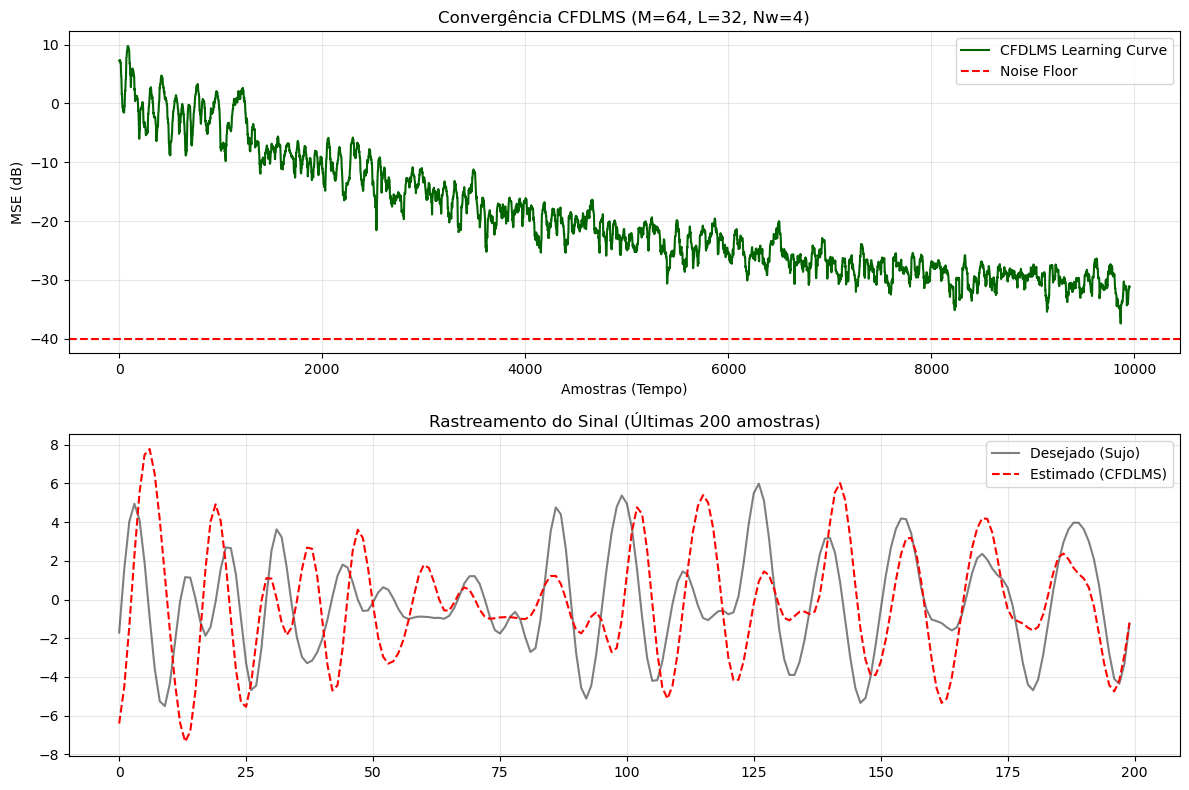

MSE Final (Regime Permanente): 9.405674e-04


In [3]:
# --- 1. Geração de Sinais (Sinal Colorido para Desafiar o Filtro) ---
def generate_data(n_samples=10000, noise_std=0.01):
    rng = np.random.default_rng(42)
    
    # Criando um sinal de entrada colorido (Processo AR)
    # Sinais correlacionados degradam o LMS, mas o CFDLMS lida bem via FFT
    b_ar, a_ar = signal.butter(4, 0.2)
    x = signal.lfilter(b_ar, a_ar, rng.standard_normal(n_samples))
    x /= np.std(x) # Normalização
    
    # Sistema Desconhecido (Planta) - Filtro FIR de 32 coeficientes
    # Vamos criar uma resposta ao impulso com decaimento
    h_unknown = np.exp(-0.1 * np.arange(32)) * np.cos(0.5 * np.arange(32))
    
    # Sinal Desejado com Ruído
    d = np.convolve(x, h_unknown, mode='full')[:n_samples]
    d += noise_std * rng.standard_normal(n_samples)
    
    return x, d, h_unknown

x, d, h_true = generate_data()

# --- 2. Configuração do CFDLMS ---
# M: Número de sub-bandas (bins de frequência)
# L: Hop size (salto). Geralmente M/2
# Nw: Ordem do filtro em cada bin (Nw+1 taps)
M = 64
L = 32
Nw = 4 # O filtro total equivalente tem cerca de (Nw+1)*L taps

model = pdf.CFDLMS(
    filter_order=Nw, 
    n_subbands=M, 
    decimation=L, 
    step_size=0.2, 
    smoothing=0.1,
    gamma=1e-3
)

# --- 3. Execução ---
res = model.optimize(x, d, verbose=True)

y = res.outputs
e = res.errors

# --- 4. Análise de Resultados ---

# Cálculo do MSE em dB (suavizado)
mse_db = 10 * np.log10(np.convolve(e**2, np.ones(L)/L, mode='valid') + 1e-12)

plt.figure(figsize=(12, 8))

# Gráfico 1: Curva de Aprendizado
plt.subplot(2, 1, 1)
plt.plot(mse_db, color='darkgreen', label='CFDLMS Learning Curve')
plt.axhline(10*np.log10(0.01**2), color='red', linestyle='--', label='Noise Floor')
plt.title(f"Convergência CFDLMS (M={M}, L={L}, Nw={Nw})")
plt.ylabel("MSE (dB)")
plt.xlabel("Amostras (Tempo)")
plt.grid(True, alpha=0.3)
plt.legend()

# Gráfico 2: Rastreamento do Sinal (Final do sinal)
plt.subplot(2, 1, 2)
plt.plot(d[-200:], 'k', alpha=0.5, label='Desejado (Sujo)')
plt.plot(y[-200:], 'r--', label='Estimado (CFDLMS)')
plt.title("Rastreamento do Sinal (Últimas 200 amostras)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Final (Regime Permanente): {np.mean(e[-500:]**2):.6e}")

# Teste 2

In [5]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(42)
L_block = 64        # Tamanho do salto (Decimação)
M_fft = 2 * L_block # Tamanho da FFT (comumente 2L para evitar aliasing)
n_blocks = 200
n_samples = n_blocks * L_block

# Entrada: Ruído branco real
x = np.random.randn(n_samples)

# Planta Desconhecida: Um filtro longo (ex: 32 taps)
# O CFDLMS é ideal quando filter_order (Nw) é grande.
filter_order_nw = 31 
w_true = np.exp(-0.1 * np.arange(filter_order_nw + 1)) * np.random.randn(filter_order_nw + 1)

# Gerando sinal desejado (convolução real)
d_clean = np.convolve(x, w_true, mode='same')
noise_std = 0.01
d = d_clean + noise_std * np.random.randn(n_samples)

In [6]:
# --- 2. EXECUÇÃO DO FILTRO CFDLMS ---
# n_subbands (M): Número de frequências (bins)
# decimation (L): Tamanho do bloco de processamento
# step_size: Passo de adaptação
filt_cfdlms = pdf.CFDLMS(
    filter_order=filter_order_nw,
    n_subbands=M_fft,
    decimation=L_block,
    step_size=0.2,
    gamma=1e-3,
    smoothing=0.1 # Fator de esquecimento para a energia das subbandas
)

result = filt_cfdlms.optimize(x, d, verbose=True, return_internal_states=True)

[CFDLMS] Completed in 26.509 ms | iters=200 | out_len=12800


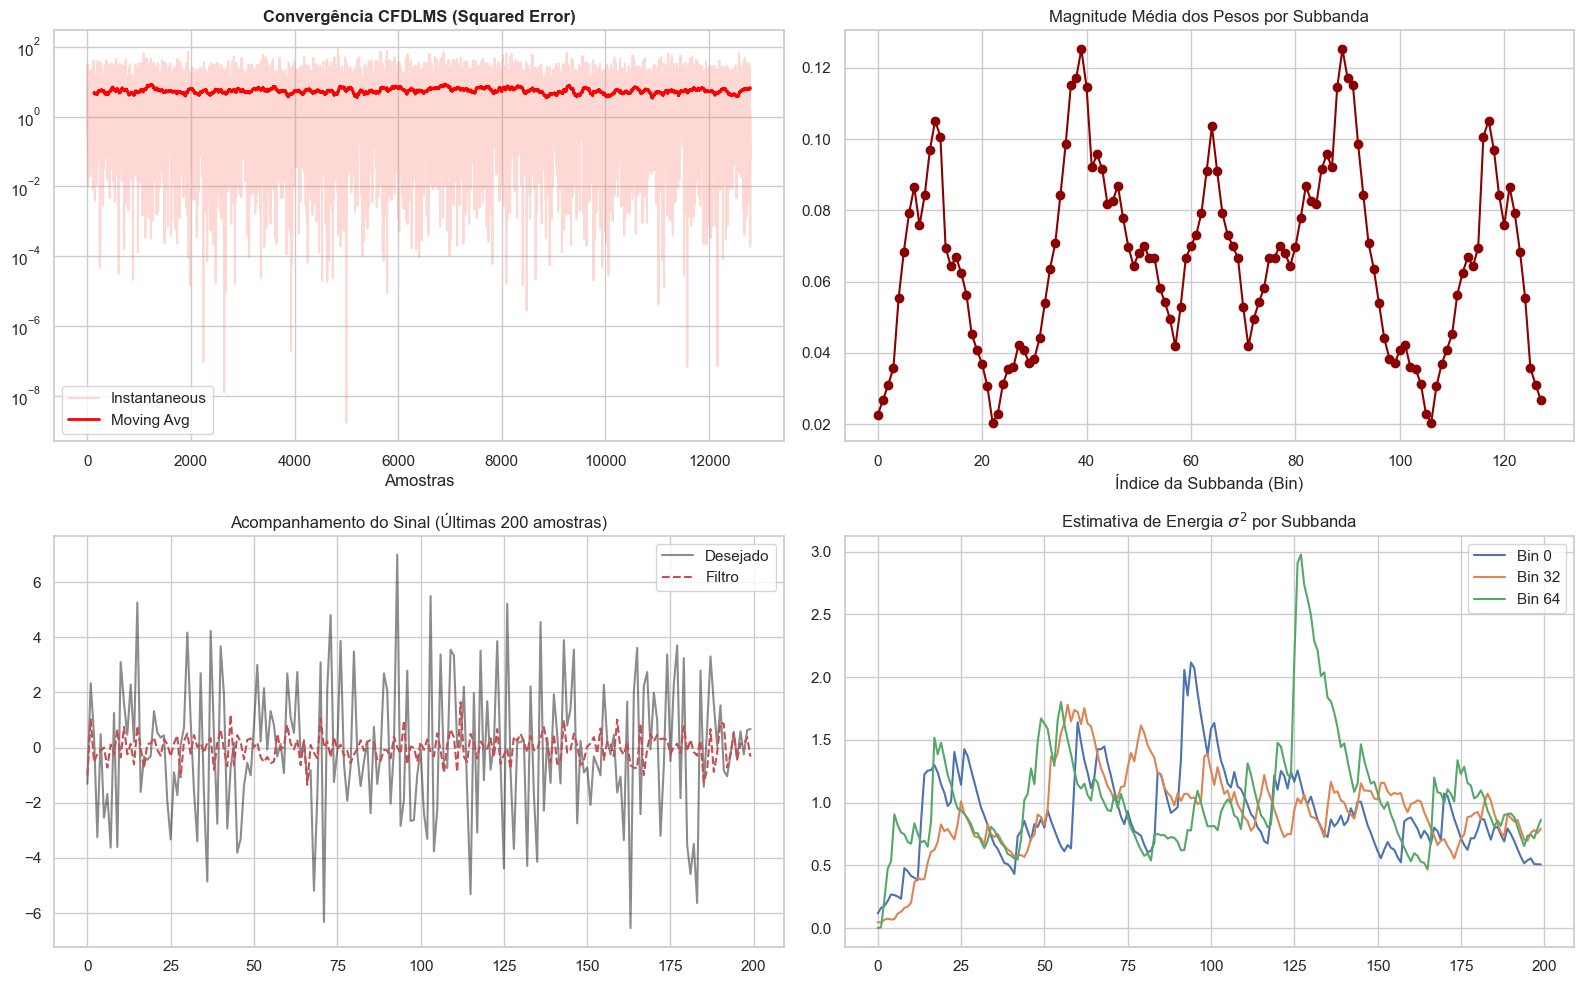

In [7]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_cfdlms_dashboard(result, x, d, L_block):
    sns.set_theme(style="whitegrid")
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2)

    # A. Erro Quadrático (MSE)
    # Como o filtro é em bloco, o MSE reflete a performance do bloco
    ax1 = fig.add_subplot(gs[0, 0])
    mse = result.errors**2
    ax1.semilogy(mse, color='salmon', alpha=0.3, label='Instantaneous')
    ax1.semilogy(pd.Series(mse).rolling(L_block*2).mean(), color='red', lw=2, label='Moving Avg')
    ax1.set_title("Convergência CFDLMS (Squared Error)", fontweight='bold')
    ax1.set_xlabel("Amostras")
    ax1.legend()

    # B. Resposta em Frequência (Magnitude dos pesos no final)
    ax2 = fig.add_subplot(gs[0, 1])
    # ww_history tem formato (iters, M, Nw+1)
    ww_final = result.extra['ww_history'][-1] 
    # Magnitude média através das subbandas
    mag_freq = np.abs(ww_final).mean(axis=1)
    ax2.plot(mag_freq, marker='o', color='darkred')
    ax2.set_title("Magnitude Média dos Pesos por Subbanda")
    ax2.set_xlabel("Índice da Subbanda (Bin)")

    # C. Sinais no tempo (Últimos blocos)
    ax3 = fig.add_subplot(gs[1, 0])
    zoom = 200
    ax3.plot(d[-zoom:], 'k', alpha=0.5, label='Desejado')
    ax3.plot(result.outputs[-zoom:], 'r--', label='Filtro')
    ax3.set_title(f"Acompanhamento do Sinal (Últimas {zoom} amostras)")
    ax3.legend()

    # D. Energia das Subbandas (sig)
    ax4 = fig.add_subplot(gs[1, 1])
    sig_history = result.extra['sig_history']
    # Plotar a energia de algumas subbandas selecionadas
    bins_to_plot = [0, M_fft//4, M_fft//2]
    for b in bins_to_plot:
        ax4.plot(sig_history[:, b], label=f'Bin {b}')
    ax4.set_title(r"Estimativa de Energia $\sigma^2$ por Subbanda")
    ax4.legend()

    plt.tight_layout()
    plt.show()

plot_cfdlms_dashboard(result, x, d, L_block)